<a href="https://colab.research.google.com/github/lbenbaccar/Toxic-Comment-Classification-Challenge/blob/main/Toxic_comments_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Toxic comments classification challenge</center>

In [ ]:
!pip install emoji
!pip install demoji
!pip install contractions
!pip install plot_keras_history
!pip install --upgrade tables
!pip install --pre --upgrade gensim
#!pip install "seaborn == 0.10.1"
!pip install transformers

Requirement already up-to-date: tables in /usr/local/lib/python3.7/dist-packages (3.6.1)
Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)


In [ ]:
import numpy as np
from numpy import asarray
from numpy import zeros
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import scipy.special
from scipy import sparse
from scipy.sparse import hstack
import matplotlib_venn as venn
import os

import time
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud
import emoji
import demoji
import contractions
from textblob import TextBlob
from gensim.models import Word2Vec
import multiprocessing
import string

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, classification_report, multilabel_confusion_matrix, roc_auc_score, average_precision_score, recall_score, precision_score, matthews_corrcoef, accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow. keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, LSTM, Embedding, Input, Bidirectional, GlobalMaxPool1D, Dropout, GRU, Flatten
from tensorflow.keras.initializers import Constant
from plot_keras_history import plot_history

from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertModel, create_optimizer, BertModel, AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from typing import Tuple, List
from functools import partial
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data exploration

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/NLP - ENSAE/train.csv')
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/NLP - ENSAE/test.csv')
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
train_df.describe(include = 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,159571,159571,273f5132e3f4902b,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comment_text,159571,159571,"Cease your unbecoming behavior immediantly, cr...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
toxic,159571,NaN,NaN,NaN,0.0958445,0.294379,0,0,0,0,1
severe_toxic,159571,NaN,NaN,NaN,0.00999555,0.0994771,0,0,0,0,1
obscene,159571,NaN,NaN,NaN,0.0529482,0.223931,0,0,0,0,1
threat,159571,NaN,NaN,NaN,0.00299553,0.0546496,0,0,0,0,1
insult,159571,NaN,NaN,NaN,0.0493636,0.216627,0,0,0,0,1
identity_hate,159571,NaN,NaN,NaN,0.00880486,0.0934205,0,0,0,0,1


In [ ]:
train_df.shape

(159571, 8)

In [ ]:
train_df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [ ]:
train_df.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [ ]:
print("Check for missing values in Train dataset")
print(train_df.isnull().sum())
print()
print("Check for missing values in Test dataset")
print(test_df.isnull().sum())

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64


In [ ]:
x=train_df.iloc[:,2:].sum()

rowsums=train_df.iloc[:,2:].sum(axis=1)
train_df['clean']=(rowsums==0)

train_df['clean'].sum()
print("Total comments = ",len(train_df))
print("Total clean comments = ",train_df['clean'].sum())
print("Total toxic comments = ",len(train_df[train_df['clean']!=1]))
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total toxic comments =  16225
Total tags = 35098


## 2. Data pre-processing

In [ ]:
train_df["split"] = "TRAIN"
test_df["split"] = "TEST"

In [ ]:
df = pd.concat([train_df, test_df]).reset_index(drop=True)
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,split
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN
...,...,...,...,...,...,...,...,...,...,...
312730,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEST
312731,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEST
312732,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEST
312733,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEST


### 2.1) Features extractions

In [ ]:
# Comments in capitals
df['capitals'] = df['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper()))
df["uppercase_comments"] = df['comment_text'].apply(lambda x: 1 if x.isupper() else 0)

In [ ]:
# Number of punctuations in comments
df['punctuations'] = df['comment_text'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

In [ ]:
# Number of emojis in comments
df['emojis'] = df['comment_text'].apply(lambda comment: sum(comment.count(s) for s in emoji.UNICODE_EMOJI))

In [ ]:
# Number of characters in comments
df['length'] = df['comment_text'].apply(len)

In [ ]:
# Number of sentences
df['sentences'] = df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)

In [ ]:
# Number of words
df['words'] = df["comment_text"].apply(lambda x: len(str(x).split()))

### 2.2) Data cleaning

In [ ]:
df["clean_comments"] = df["comment_text"].apply(lambda x: x.lower())

In [ ]:
df["clean_comments"] = df["clean_comments"].apply(lambda x: contractions.fix(x))

In [ ]:
def remove_URL(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)

def remove_html(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7f]',r'', text)

def remove_special_characters(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F' 
        u'\U0001F300-\U0001F5FF'  
        u'\U0001F680-\U0001F6FF'  
        u'\U0001F1E0-\U0001F1FF' 
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [ ]:
df["clean_comments"] = df["clean_comments"].apply(lambda x: remove_URL(x))

In [ ]:
df["clean_comments"] = df["clean_comments"].apply(lambda x: remove_html(x))

In [ ]:
df["clean_comments"] = df["clean_comments"].apply(lambda x: remove_non_ascii(x))

In [ ]:
df["clean_comments"] = df["clean_comments"].apply(lambda x: remove_punct(x))

In [ ]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
df['clean_comments'] = df['clean_comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
filename = "/content/drive/MyDrive/NLP - ENSAE/clean_df.hdf5"
key = "CleanData"
df.to_hdf(path_or_buf = filename,  key = key, mode='w')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['id', 'comment_text', 'clean', 'split', 'clean_comments'], dtype='object')]

  encoding=encoding,


## 3. Data visualization

In [ ]:
filename = "/content/drive/MyDrive/NLP - ENSAE/clean_df.hdf5"
key = "CleanData"
df = pd.read_hdf(filename, key)

In [ ]:
train_df = df.loc[df.split == "TRAIN"].reset_index(drop=True)
train_df.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,split,capitals,uppercase_comments,punctuations,emojis,length,sentences,words,clean_comments
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN,17,0,10,2,264,2,43,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN,8,0,12,2,112,1,17,daww matches background colour I seemingly stu...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN,4,0,6,2,233,1,42,hey man I really trying edit war guy constantl...


In [ ]:
test_df = df.loc[df.split == "TEST"].reset_index(drop=True)
test_df.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,split,capitals,uppercase_comments,punctuations,emojis,length,sentences,words,clean_comments
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEST,4,0,12,10,367,1,72,yo bitch ja rule succesful ever hating sad mof...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEST,7,0,6,2,50,3,12,rfc title fine I going
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEST,4,0,8,1,54,5,12,sources zawe ashton lapland


In [ ]:
types = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

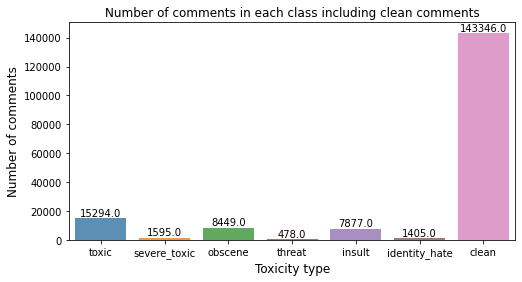

In [ ]:
x = train_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate", "clean"]].sum()

plt.figure(figsize=(8,4))
ax= sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Number of comments in each class including clean comments")
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Toxicity type', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

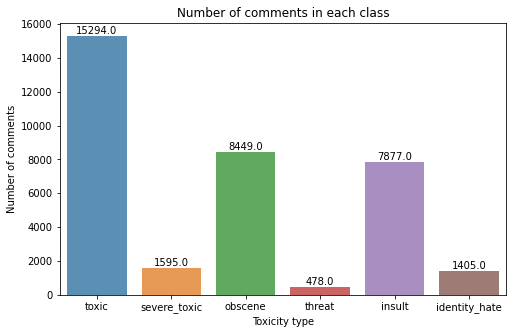

In [ ]:
val_counts = train_df[types].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(x=val_counts.index, y=val_counts.values, alpha=0.8)

plt.title("Number of comments in each class")
plt.xlabel("Toxicity type")
plt.ylabel("Number of comments")

rects = ax.patches
labels = val_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha="center", va="bottom")
    
plt.show()

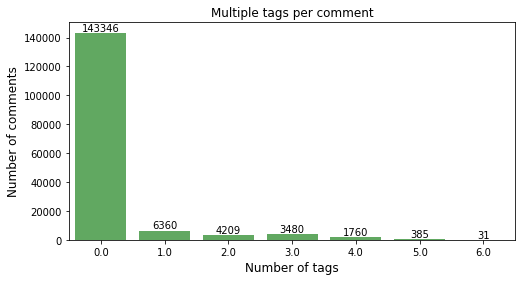

In [ ]:
# Number of classes the comment belongs to
train_df["total"] = train_df[types].sum(axis=1)
x=train_df.total.value_counts()

plt.figure(figsize=(8,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of tags', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

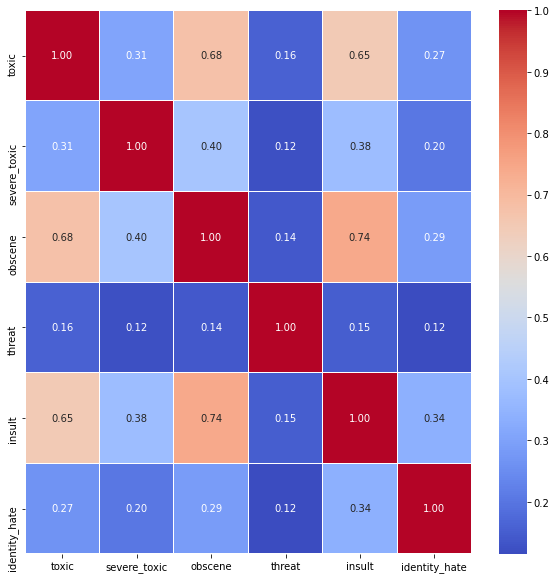

In [ ]:
temp_df = train_df[types]
corr=temp_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,
            cmap="coolwarm",
            fmt='.2f',
            linewidths=.05,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

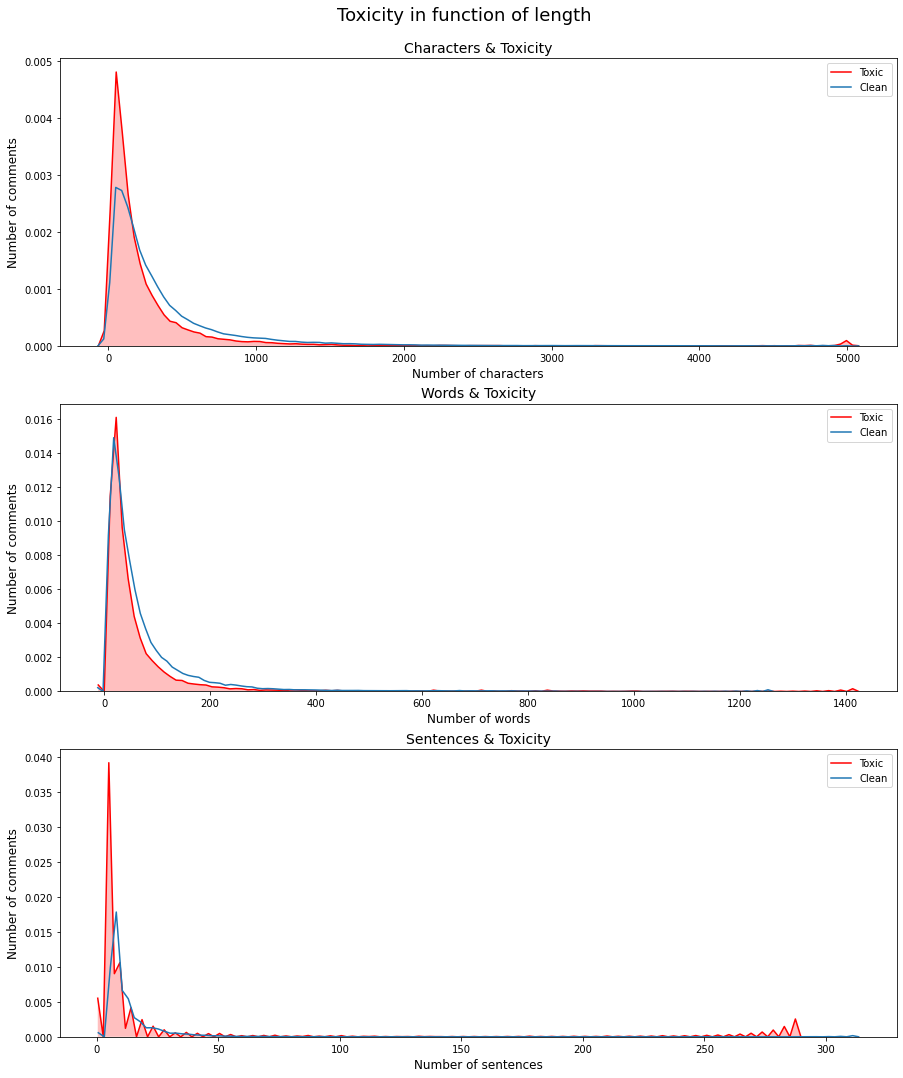

In [ ]:
plt.figure(figsize=(15,18))
plt.suptitle("Toxicity in function of length",y=0.92,fontsize=18)
plt.tight_layout()

# Number of characters
plt.subplot(311)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "length"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "length"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of characters', fontsize=12)
plt.title("Characters & Toxicity", fontsize=14)

# Number of words
plt.subplot(312)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "words"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "words"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of words', fontsize=12)
plt.title("Words & Toxicity", fontsize=14)

# Number of sentences
plt.subplot(313)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "sentences"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "sentences"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of sentences', fontsize=12)
plt.title("Sentences & Toxicity", fontsize=14)

plt.show()

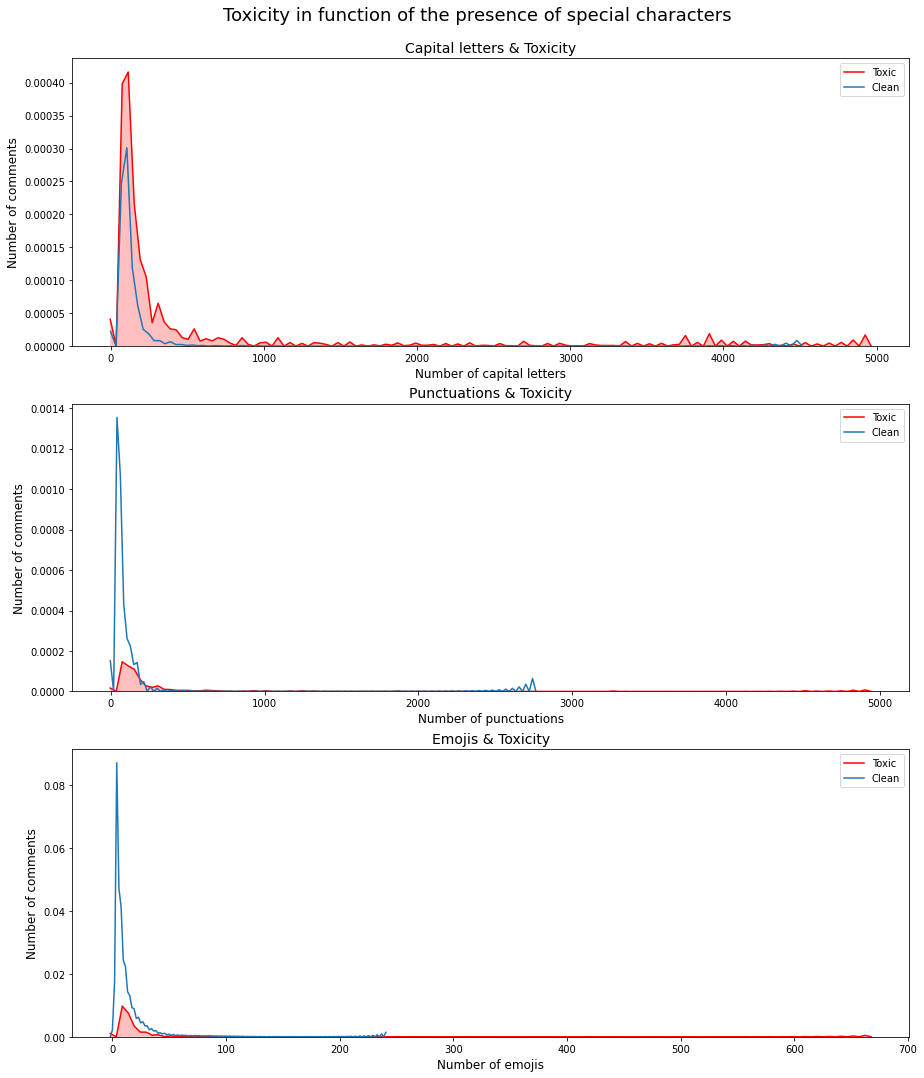

In [ ]:
plt.figure(figsize=(15,18))
plt.suptitle("Toxicity in function of the presence of special characters",y=0.92,fontsize=18)
plt.tight_layout()

plt.subplot(311)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "capitals"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "capitals"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of capital letters', fontsize=12)
plt.title("Capital letters & Toxicity", fontsize=14)

plt.subplot(312)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "punctuations"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "punctuations"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of punctuations', fontsize=12)
plt.title("Punctuations & Toxicity", fontsize=14)

plt.subplot(313)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "emojis"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "emojis"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of emojis', fontsize=12)
plt.title("Emojis & Toxicity", fontsize=14)

plt.show()

In [ ]:
compteur = 0
variables = []
values = []

for i in range(len(types)):
    for j in range(i+1, len(types)) :
        compteur += 1
        variables.append(str(types[i] + " & " + types[j]))
        values.append(train_df.loc[(train_df.total == 2) & (train_df[types[i]] == 1) & (train_df[types[j]] == 1)].shape[0])

In [ ]:
assert compteur == scipy.special.binom(6, 2)
assert sum(values) == train_df.loc[train_df.total == 2].shape[0]

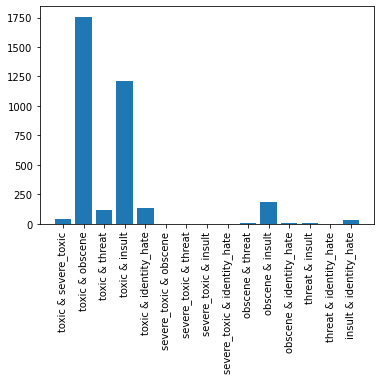

In [ ]:
y_pos = range(len(variables))
plt.bar(y_pos, values)
plt.xticks(y_pos, variables, rotation=90)
plt.show()

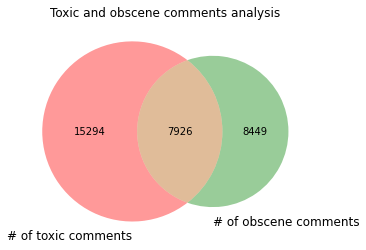

In [ ]:
toxic_com = set(train_df.loc[train_df.toxic == 1, "id"].tolist())
obscene_com = set(train_df.loc[train_df.obscene == 1, "id"].tolist())
common_com = list(toxic_com.intersection(obscene_com))
plt.title("Toxic and obscene comments analysis")
venn.venn2(subsets=(len(toxic_com),len(obscene_com),len(common_com)),set_labels=("# of toxic comments","# of obscene comments"))
plt.show()

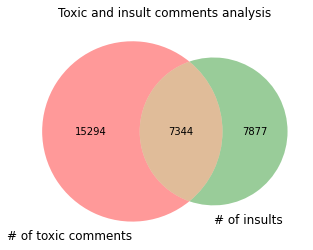

In [ ]:
toxic_com = set(train_df.loc[train_df.toxic == 1, "id"].tolist())
insult_com = set(train_df.loc[train_df.insult == 1, "id"].tolist())
common_com = list(toxic_com.intersection(insult_com))
plt.title("Toxic and insult comments analysis")
venn.venn2(subsets=(len(toxic_com),len(insult_com),len(common_com)),set_labels=("# of toxic comments","# of insults"))
plt.show()

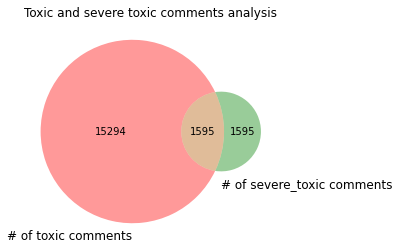

In [ ]:
toxic_com = set(train_df.loc[train_df.toxic == 1, "id"].tolist())
severe_toxic_com = set(train_df.loc[train_df.severe_toxic == 1, "id"].tolist())
common_com = list(toxic_com.intersection(severe_toxic_com))
plt.title("Toxic and severe toxic comments analysis")
venn.venn2(subsets=(len(toxic_com),len(severe_toxic_com),len(common_com)),set_labels=("# of toxic comments","# of severe_toxic comments"))
plt.show()

In [ ]:
compteur = 0
variables = []
values = []

for i in range(len(types)):
    for j in range(i+1, len(types)) :
        for k in range(j+1, len(types)) :
            compteur += 1
            variables.append(str(types[i] + " & " + types[j] + " & " + types[k]))
            values.append(train_df.loc[(train_df.total == 3) &
                                       (train_df[types[i]] == 1) &
                                       (train_df[types[j]] == 1) &
                                       (train_df[types[k]] == 1)].shape[0])

In [ ]:
assert compteur == scipy.special.binom(6, 3)
assert sum(values) == train_df.loc[train_df.total == 3].shape[0]

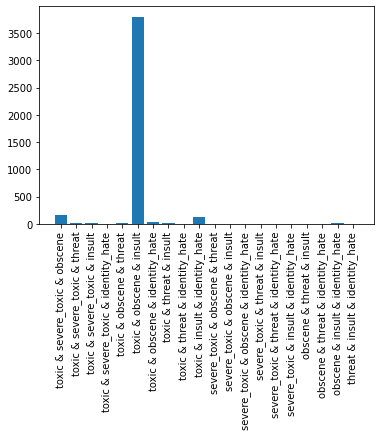

In [ ]:
y_pos = range(len(variables))
plt.bar(y_pos, values)
plt.xticks(y_pos, variables, rotation=90)
plt.show()

In [ ]:
word_counter = {}

for categ in types:
    d = Counter()
    train_df[train_df[categ] == 1]['clean_comments'].apply(lambda t: d.update(t.split()))
    word_counter[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

In [ ]:
%matplotlib inline

(-0.5, 399.5, 199.5, -0.5)

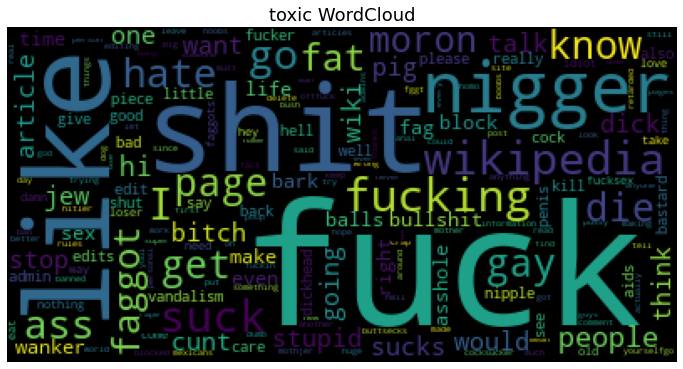

In [ ]:
w = 'toxic'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

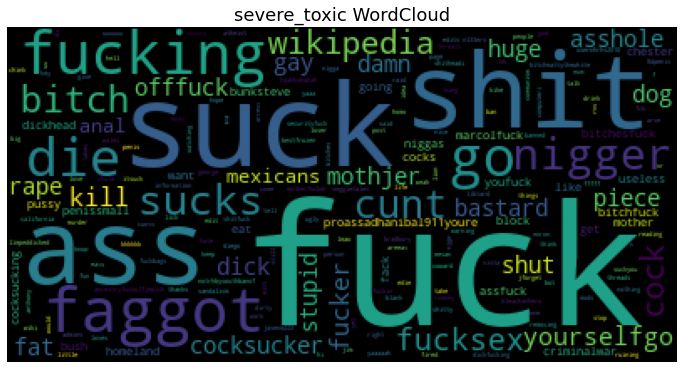

In [ ]:
w = 'severe_toxic'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

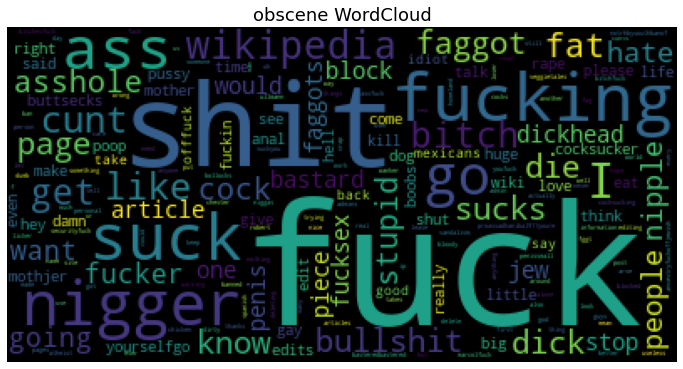

In [ ]:
w = 'obscene'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

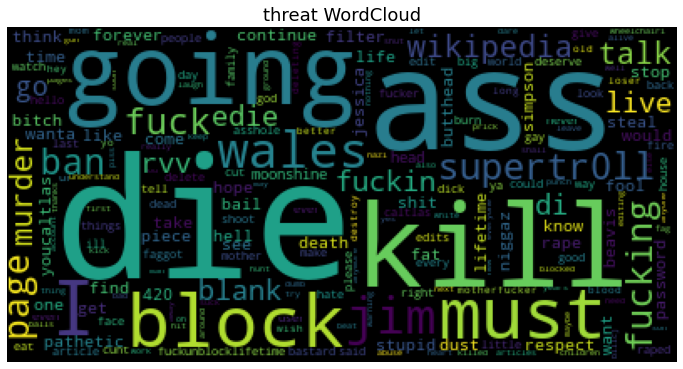

In [ ]:
w = 'threat'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

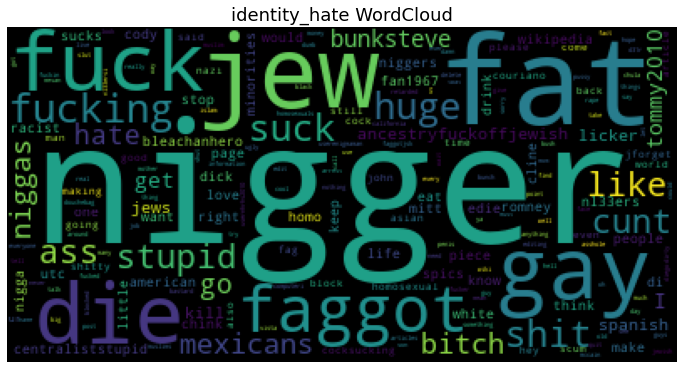

In [ ]:
w = 'identity_hate'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

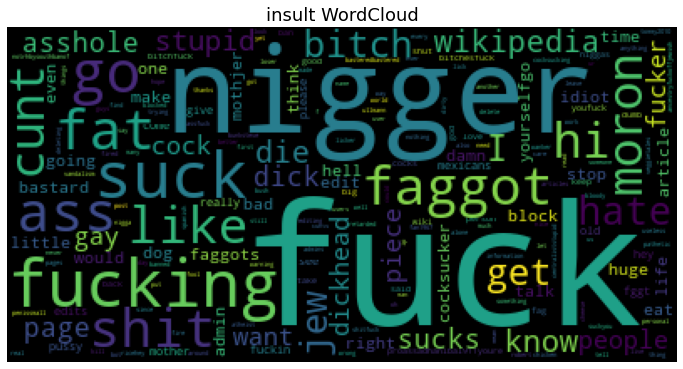

In [ ]:
w = 'insult'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

## 4. Modeling

### 4.1) Baseline model

In [ ]:
for target in types:
    comments = train_df["clean_comments"]
    comments_vector = TfidfVectorizer(max_features=20000, analyzer='word')
    X = comments_vector.fit_transform(comments)
    y = train_df[target]

    comments_train, comments_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        
    classifier = LogisticRegression(random_state=0, max_iter=200)
    classifier.fit(comments_train, y_train)
    y_pred = classifier.predict(comments_test)
    print(target + ' score: %.4f' % f1_score(y_test, y_pred))

toxic score: 0.7141
severe_toxic score: 0.2870
obscene score: 0.7337
threat score: 0.1342
insult score: 0.6235
identity_hate score: 0.2709


###### Let's add the features we extracted for the comments in the previous part.

In [ ]:
comments = train_df["clean_comments"]
comments_vector = TfidfVectorizer(max_features=10000, analyzer='word')
comments_matrix = comments_vector.fit_transform(comments)
engineered_features = ['capitals', 'uppercase_comments', 'punctuations', 'emojis', 'length', 'sentences', 'words']
features_matrix = train_df[engineered_features].values
X_new_features = sparse.hstack((comments_matrix, features_matrix))

print(comments_matrix.shape)
print(features_matrix.shape)
print(X_new_features.shape)

(159571, 10000)
(159571, 7)
(159571, 10007)


In [ ]:
for target in types:
    y = train_df[target]
    comments_train, comments_test, y_train, y_test = train_test_split(X_new_features, y, test_size=0.3, random_state=0)
    
    pipeline_steps = [('scaler', StandardScaler(with_mean=False)), ('classifier', LogisticRegression(random_state=0))]
    pipeline_steps = Pipeline(steps=pipeline_steps)
    grid = [{'classifier__max_iter': [1000, 1200]}]
    gridsearch = GridSearchCV(estimator=pipeline_steps, param_grid=grid, cv=3, scoring=make_scorer(f1_score))
    gridsearch.fit(comments_train, y_train)
    print(target + ' score: %0.3f' % gridsearch.best_score_)


toxic score: 0.612
severe_toxic score: 0.256
obscene score: 0.572
threat score: 0.311
insult score: 0.459
identity_hate score: 0.226


### 4.1) Single task models

In [ ]:
MAX_LEN = max([len(s.split()) for s in df["clean_comments"]]) ; MAX_LEN

1250

#### 4.1.1) OneHot Embedding

In [ ]:
EMBD_DIM = 200
save_models = "/content/drive/MyDrive/NLP - ENSAE/Models/OneHot/"

In [ ]:
sentences = train_df["clean_comments"].to_list()
OneHot = [one_hot(d, EMBD_DIM) for d in sentences]
padded_sentences = pad_sequences(OneHot, maxlen=MAX_LEN, padding='post')

In [ ]:
model_OneHot = Sequential()
embedding_layer = Embedding(EMBD_DIM, 8, input_length=MAX_LEN)
model_OneHot.add(embedding_layer)
model_OneHot.add(Flatten())
model_OneHot.add(Dense(1, activation='sigmoid'))
model_OneHot.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
for CLASS_TO_PRED in types:
    target = train_df[CLASS_TO_PRED].values
    X_train_pad, X_test_pad, y_train, y_test = train_test_split(padded_sentences, target, test_size=0.3, random_state=0)
    
    model_name = str(CLASS_TO_PRED) + ".log"
    file_path = save_models + model_name
    csv_logger = CSVLogger(file_path, separator=',', append=False)
    history_OneHot = model_OneHot.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), callbacks = [csv_logger]) #verbose=0
    y_pred_OneHot = (model_OneHot.predict(X_test_pad) > 0.5).astype("int32")
    y_pred_OneHot = y_pred_OneHot[:, 0]
    print(CLASS_TO_PRED + ' F1 score: %.4f' % f1_score(y_test, y_pred_OneHot))
    print("------------------------------------------------------------------------------------------------------")

Epoch 1/10
3491/3491 [==============================] - 15s 4ms/step - loss: 0.2856 - accuracy: 0.9076 - val_loss: 0.2534 - val_accuracy: 0.9137
Epoch 2/10
3491/3491 [==============================] - 14s 4ms/step - loss: 0.2445 - accuracy: 0.9162 - val_loss: 0.2552 - val_accuracy: 0.9132
Epoch 3/10
3491/3491 [==============================] - 14s 4ms/step - loss: 0.2451 - accuracy: 0.9162 - val_loss: 0.2542 - val_accuracy: 0.9132
Epoch 4/10
3491/3491 [==============================] - 14s 4ms/step - loss: 0.2420 - accuracy: 0.9159 - val_loss: 0.2527 - val_accuracy: 0.9149
Epoch 5/10
3491/3491 [==============================] - 14s 4ms/step - loss: 0.2387 - accuracy: 0.9171 - val_loss: 0.2530 - val_accuracy: 0.9151
Epoch 6/10
3491/3491 [==============================] - 14s 4ms/step - loss: 0.2374 - accuracy: 0.9171 - val_loss: 0.2543 - val_accuracy: 0.9145
Epoch 7/10
3491/3491 [==============================] - 14s 4ms/step - loss: 0.2361 - accuracy: 0.9170 - val_loss: 0.2556 - val_ac

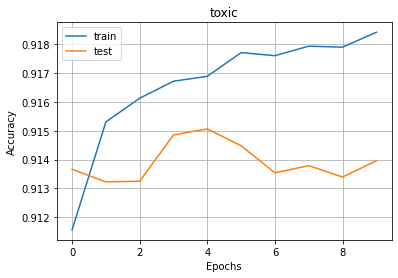

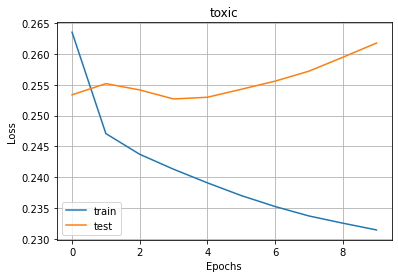

------------------------------------------------------------------------------------------------------


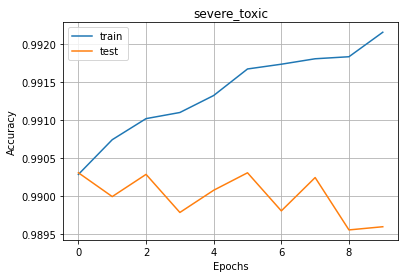

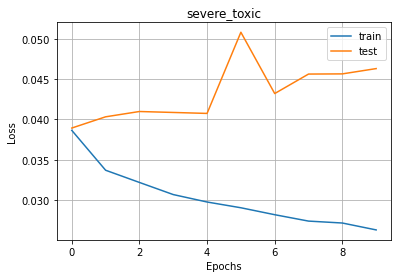

------------------------------------------------------------------------------------------------------


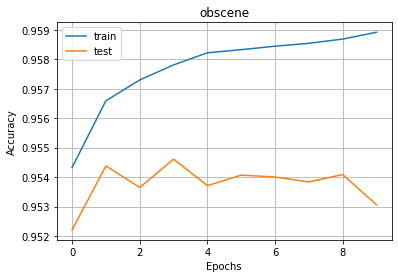

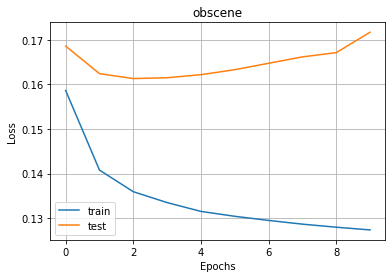

------------------------------------------------------------------------------------------------------


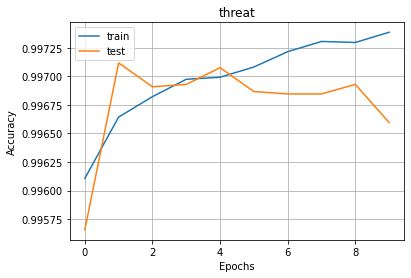

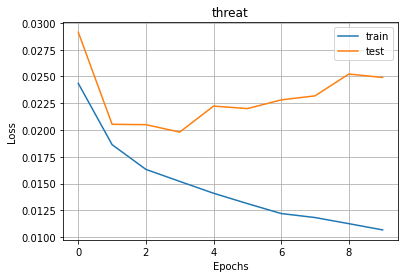

------------------------------------------------------------------------------------------------------


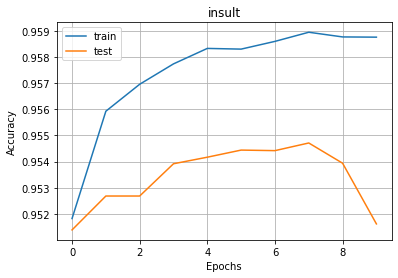

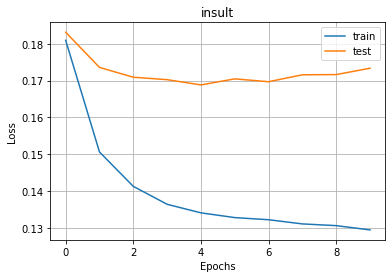

------------------------------------------------------------------------------------------------------


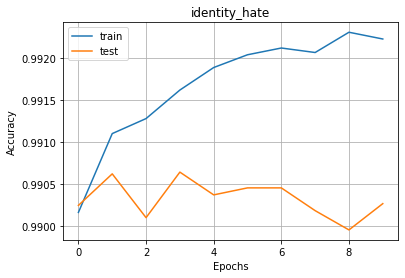

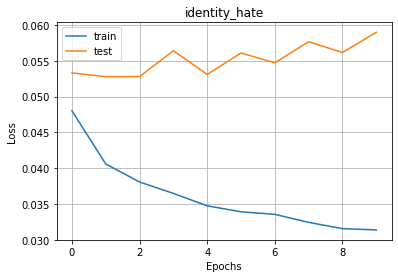

------------------------------------------------------------------------------------------------------


In [ ]:
for CLASS_TO_PRED in types:
    model_name = str(CLASS_TO_PRED) + ".log"
    file_path = save_models + model_name
    history = pd.read_csv(file_path)
    epochs = history.epoch
    
    # accuracy graph
    train_accuracy = history.accuracy
    test_accuracy = history.val_accuracy
    plt.plot(epochs, train_accuracy, label = "train")
    plt.plot(epochs, test_accuracy, label = "test")
    plt.legend()
    plt.title(CLASS_TO_PRED)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
    
    # loss graph
    train_loss = history.loss
    test_loss = history.val_loss
    plt.plot(epochs, train_loss, label = "train")
    plt.plot(epochs, test_loss, label = "test")
    plt.legend()
    plt.title(CLASS_TO_PRED)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    print("------------------------------------------------------------------------------------------------------")

#### 4.1.2) Word2vec Embeddings

In [ ]:
EMBD_DIM = 200
save_models = "/content/drive/MyDrive/NLP - ENSAE/Models/Word2Vec/"

In [ ]:
sentences_split = train_df["clean_comments"].apply(lambda x: x.split()).to_list()
w2v = Word2Vec(sentences_split, vector_size=EMBD_DIM, window=5, min_count=5, negative=15, workers=multiprocessing.cpu_count())
word_vectors = w2v.wv
filepath = "/content/drive/MyDrive/NLP - ENSAE/project_embd_w2v.txt"
word_vectors.save_word2vec_format(filepath, binary=False)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences_split)
sequences = tokenizer.texts_to_sequences(sentences_split)
padded_sentences = pad_sequences(sequences, maxlen=MAX_LEN)

In [ ]:
print("Vocabulary size:", len(word_vectors))
print()
result = word_vectors.similar_by_word("bitch")
print(result[:3])
print()
result = word_vectors.most_similar("fuck")
print(result[:3])
print()
result = word_vectors.most_similar_cosmul("fat")
print(result[:3])
print()
result = word_vectors.most_similar_cosmul(positive = ["kill", "gay"])
print(result[:3])

Vocabulary size: 44276

[('motherfucker', 0.780860960483551), ('fuckin', 0.7769833207130432), ('prick', 0.7633281350135803)]

[('cunt', 0.672640323638916), ('niggertard', 0.6675109267234802), ('wtf', 0.6290590167045593)]

[('dumbass', 0.8702497482299805), ('bitches', 0.8665902614593506), ('sannse', 0.8554270267486572)]

[('gays', 0.6023172736167908), ('cuz', 0.5996353030204773), ('butt', 0.5896778702735901)]


In [ ]:
embedding_index = {}
f = open(os.path.join(filepath), encoding = "utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embedding_index[word] = coefs
f.close()

In [ ]:
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBD_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model_w2v = Sequential()
embedding_layer = Embedding(num_words, EMBD_DIM,
                           embeddings_initializer=Constant(embedding_matrix),
                           input_length=MAX_LEN,
                           trainable=False)
model_w2v.add(embedding_layer)
model_w2v.add(Flatten())
model_w2v.add(Dense(1, activation='sigmoid'))
model_w2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
for CLASS_TO_PRED in types:
    target = train_df[CLASS_TO_PRED].values
    X_train_pad, X_test_pad, y_train, y_test = train_test_split(padded_sentences, target, test_size=0.3, random_state=0)
    
    model_name = str(CLASS_TO_PRED) + ".log"
    file_path = save_models + model_name
    csv_logger = CSVLogger(file_path, separator=',', append=False)
    history_w2v = model_w2v.fit(X_train_pad, y_train, batch_size=128, epochs=10, validation_data=(X_test_pad, y_test), callbacks = [csv_logger]) #verbose=0
    
    y_pred_w2v = (model_w2v.predict(X_test_pad) > 0.5).astype("int32")
    y_pred_w2v = y_pred_w2v[:, 0]
    print(CLASS_TO_PRED + ' F1 score: %.4f' % f1_score(y_test, y_pred_w2v))
    print("------------------------------------------------------------------------------------------------------")

Epoch 1/10
873/873 [==============================] - 102s 116ms/step - loss: 0.1389 - accuracy: 0.9536 - val_loss: 0.2160 - val_accuracy: 0.9403
Epoch 2/10
873/873 [==============================] - 102s 117ms/step - loss: 0.1322 - accuracy: 0.9558 - val_loss: 0.2282 - val_accuracy: 0.9401
Epoch 3/10
873/873 [==============================] - 101s 115ms/step - loss: 0.1243 - accuracy: 0.9579 - val_loss: 0.2416 - val_accuracy: 0.9378
Epoch 4/10
873/873 [==============================] - 101s 116ms/step - loss: 0.1263 - accuracy: 0.9585 - val_loss: 0.2516 - val_accuracy: 0.9395
Epoch 5/10
873/873 [==============================] - 104s 119ms/step - loss: 0.1203 - accuracy: 0.9591 - val_loss: 0.2683 - val_accuracy: 0.9405
Epoch 6/10
873/873 [==============================] - 102s 116ms/step - loss: 0.1205 - accuracy: 0.9603 - val_loss: 0.2768 - val_accuracy: 0.9415
Epoch 7/10
873/873 [==============================] - 101s 115ms/step - loss: 0.1204 - accuracy: 0.9605 - val_loss: 0.2758 -

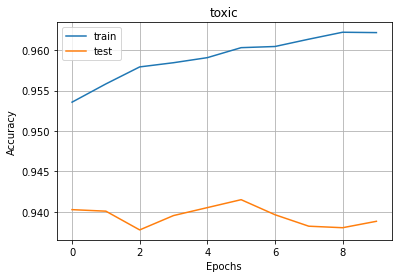

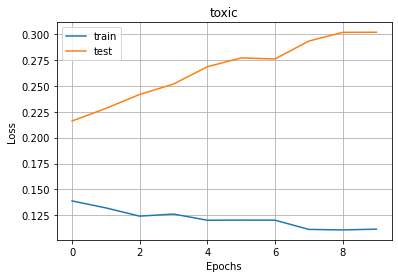

------------------------------------------------------------------------------------------------------


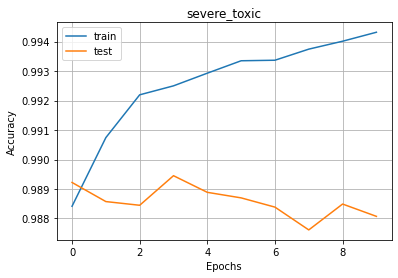

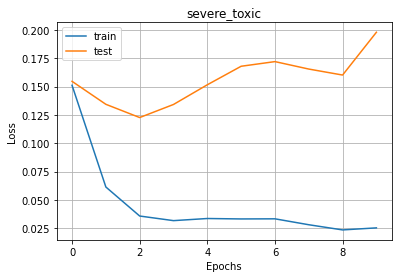

------------------------------------------------------------------------------------------------------


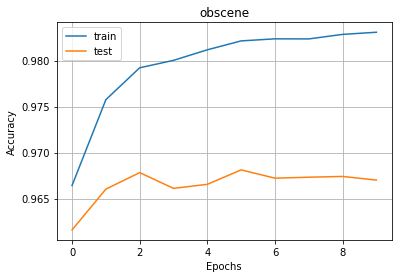

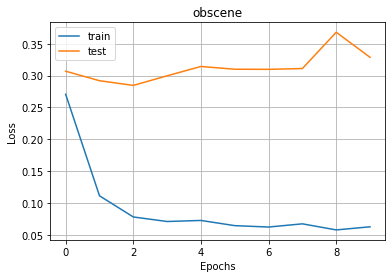

------------------------------------------------------------------------------------------------------


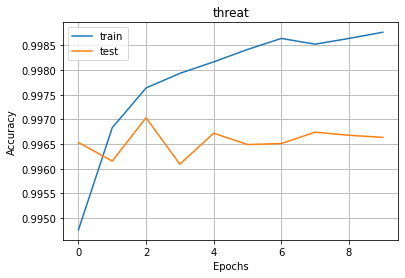

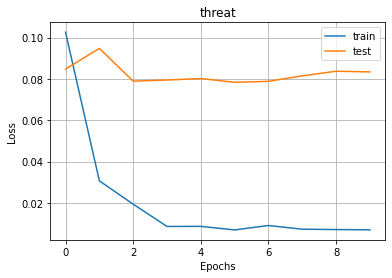

------------------------------------------------------------------------------------------------------


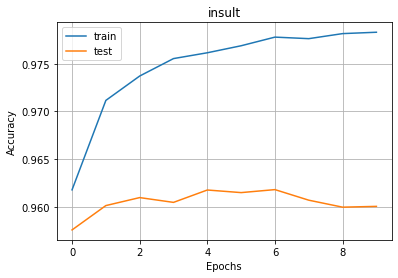

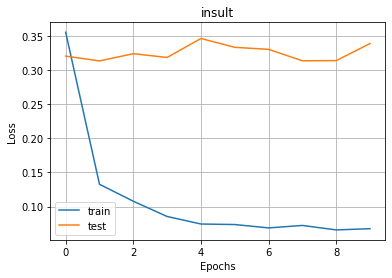

------------------------------------------------------------------------------------------------------


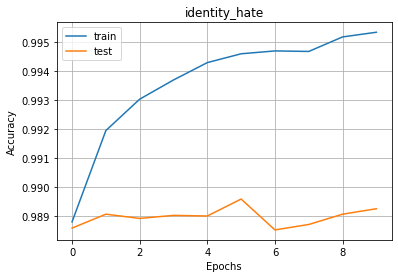

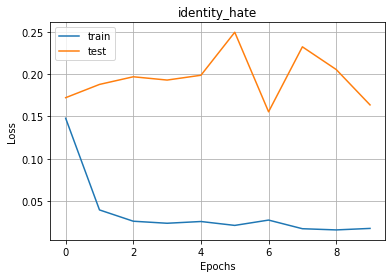

------------------------------------------------------------------------------------------------------


In [ ]:
for CLASS_TO_PRED in types:
    model_name = str(CLASS_TO_PRED) + ".log"
    file_path = save_models + model_name
    history = pd.read_csv(file_path)
    epochs = history.epoch
    
    # accuracy graph
    train_accuracy = history.accuracy
    test_accuracy = history.val_accuracy
    plt.plot(epochs, train_accuracy, label = "train")
    plt.plot(epochs, test_accuracy, label = "test")
    plt.legend()
    plt.title(CLASS_TO_PRED)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
    
    # loss graph
    train_loss = history.loss
    test_loss = history.val_loss
    plt.plot(epochs, train_loss, label = "train")
    plt.plot(epochs, test_loss, label = "test")
    plt.legend()
    plt.title(CLASS_TO_PRED)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    print("------------------------------------------------------------------------------------------------------")

#### 4.1.3) Glove Embeddings

In [ ]:
EMBD_DIM = 100
save_models = "/content/drive/MyDrive/NLP - ENSAE/Models/Glove/"

In [ ]:
sentences = train_df["clean_comments"].to_list()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
padded_sentences = pad_sequences(sequences, MAX_LEN, padding='post')

In [ ]:
embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/NLP - ENSAE/glove.6B.100d.txt', encoding="utf8")

In [ ]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

In [ ]:
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBD_DIM))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
model_Glove = Sequential()
embedding_layer = Embedding(num_words, EMBD_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_LEN,
                            trainable=False)
model_Glove.add(embedding_layer)
model_Glove.add(Flatten())
model_Glove.add(Dense(1, activation='sigmoid'))
model_Glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
for CLASS_TO_PRED in types:
    target = train_df[CLASS_TO_PRED].values
    X_train_pad, X_test_pad, y_train, y_test = train_test_split(padded_sentences, target, test_size=0.3, random_state=0)
    
    model_name = str(CLASS_TO_PRED) + ".log"
    file_path = save_models + model_name
    csv_logger = CSVLogger(file_path, separator=',', append=False)
    history_Glove = model_Glove.fit(padded_sentences, target, epochs=10, validation_data=(X_test_pad, y_test), callbacks = [csv_logger]) #verbose=0
    
    y_pred_Glove = (model_Glove.predict(X_test_pad) > 0.5).astype("int32")
    y_pred_Glove = y_pred_Glove[:, 0]
    print(CLASS_TO_PRED + ' F1 score: %.4f' % f1_score(y_test, y_pred_Glove))
    print("------------------------------------------------------------------------------------------------------")

Epoch 1/10
4987/4987 [==============================] - 70s 14ms/step - loss: 0.2232 - accuracy: 0.9274 - val_loss: 0.1632 - val_accuracy: 0.9433
Epoch 2/10
4987/4987 [==============================] - 72s 15ms/step - loss: 0.1699 - accuracy: 0.9407 - val_loss: 0.1656 - val_accuracy: 0.9426
Epoch 3/10
4987/4987 [==============================] - 64s 13ms/step - loss: 0.1617 - accuracy: 0.9441 - val_loss: 0.1475 - val_accuracy: 0.9475
Epoch 4/10
4987/4987 [==============================] - 66s 13ms/step - loss: 0.1494 - accuracy: 0.9462 - val_loss: 0.1425 - val_accuracy: 0.9486
Epoch 5/10
4987/4987 [==============================] - 65s 13ms/step - loss: 0.1536 - accuracy: 0.9450 - val_loss: 0.1419 - val_accuracy: 0.9486
Epoch 6/10
4987/4987 [==============================] - 66s 13ms/step - loss: 0.1495 - accuracy: 0.9471 - val_loss: 0.1428 - val_accuracy: 0.9495
Epoch 7/10
4987/4987 [==============================] - 64s 13ms/step - loss: 0.1478 - accuracy: 0.9472 - val_loss: 0.1431 -

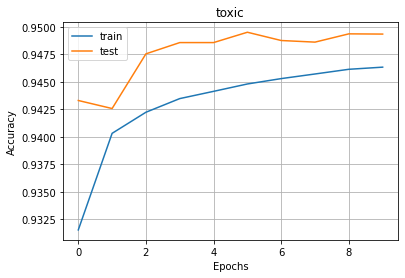

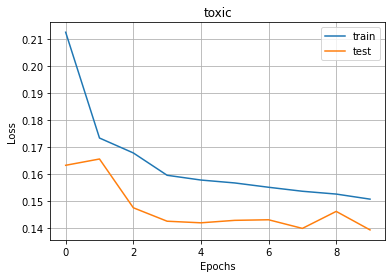

------------------------------------------------------------------------------------------------------


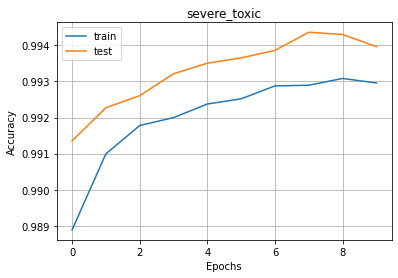

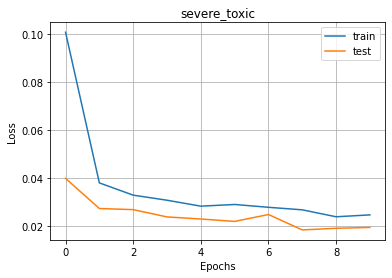

------------------------------------------------------------------------------------------------------


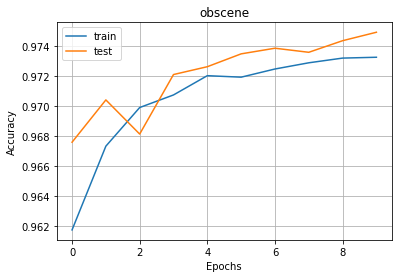

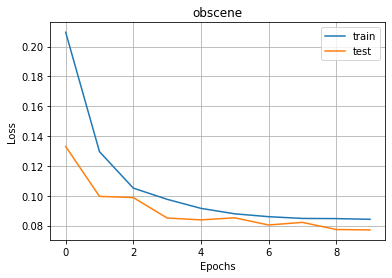

------------------------------------------------------------------------------------------------------


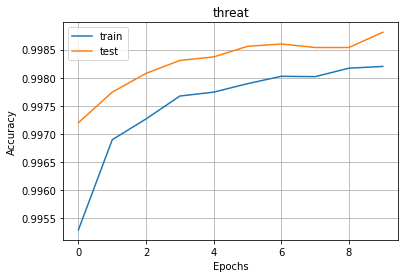

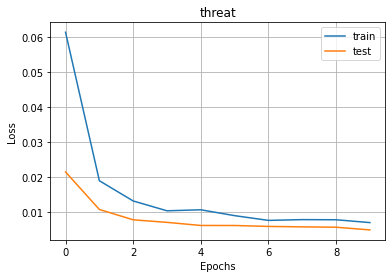

------------------------------------------------------------------------------------------------------


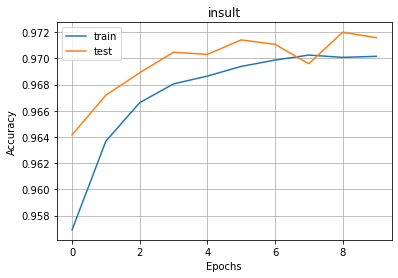

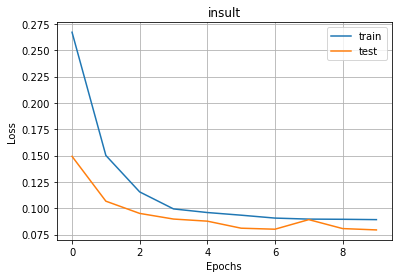

------------------------------------------------------------------------------------------------------


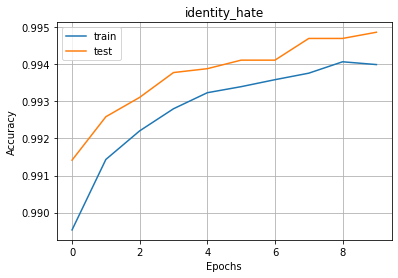

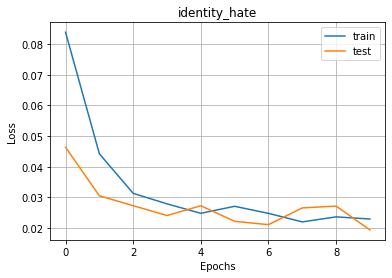

------------------------------------------------------------------------------------------------------


In [ ]:
for CLASS_TO_PRED in types:
    model_name = str(CLASS_TO_PRED) + ".log"
    file_path = save_models + model_name
    history = pd.read_csv(file_path)
    epochs = history.epoch
    
    # accuracy graph
    train_accuracy = history.accuracy
    test_accuracy = history.val_accuracy
    plt.plot(epochs, train_accuracy, label = "train")
    plt.plot(epochs, test_accuracy, label = "test")
    plt.legend()
    plt.title(CLASS_TO_PRED)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
    
    # loss graph
    train_loss = history.loss
    test_loss = history.val_loss
    plt.plot(epochs, train_loss, label = "train")
    plt.plot(epochs, test_loss, label = "test")
    plt.legend()
    plt.title(CLASS_TO_PRED)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    print("------------------------------------------------------------------------------------------------------")

### 4.2) Multi tasks model

#### 4.2.1)  LSTM

In [43]:
y = train_df[types].values

In [44]:
max_features = 20000
maxlen = 200
sentences = train_df["clean_comments"].to_list()
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
padded_sentences = pad_sequences(sequences, maxlen, padding='post')

In [45]:
X_train_pad, X_test_pad, y_train, y_test = train_test_split(padded_sentences, y, test_size=0.3, random_state=0)

In [46]:
inp = Input(shape=(maxlen, )) 
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
batch_size = 32
epochs = 2
model.fit(X_train_pad, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
3142/3142 [==============================] - 328s 104ms/step - loss: 0.1706 - accuracy: 0.7492 - val_loss: 0.1387 - val_accuracy: 0.9944
Epoch 2/2
3142/3142 [==============================] - 315s 100ms/step - loss: 0.1411 - accuracy: 0.9841 - val_loss: 0.1409 - val_accuracy: 0.9944


In [48]:
y_pred = model.predict([X_test_pad], batch_size=1024, verbose=1)

47/47 [==============================] - 16s 342ms/step


In [49]:
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1

In [50]:
y_int = pd.DataFrame(y_int)
y_int.rename(columns = {0 : 'toxic',
                              1 : 'severe_toxic',
                              2 : 'obscene',
                              3 : 'threat',
                              4 : 'insult',
                              5 : 'identity_hate'}, inplace = True)

In [51]:
y_test_l = pd.DataFrame(y_test)
y_test_l.rename(columns = {0 : 'toxic',
                              1 : 'severe_toxic',
                              2 : 'obscene',
                              3 : 'threat',
                              4 : 'insult',
                              5 : 'identity_hate'}, inplace = True)

In [54]:
for i in types:
    yi_pred = y_int[i]
    yi_test = y_test_l[i]
    print('Accuracy: %.4f' % accuracy_score(yi_test, yi_pred))

Accuracy: 0.9041
Accuracy: 0.9899
Accuracy: 0.9472
Accuracy: 0.9973
Accuracy: 0.9507
Accuracy: 0.9910


In [55]:
print('Accuracy is {}'.format(accuracy_score(y_test,y_int)))

Accuracy is 0.897894385026738


***2ème LSTM test***

In [ ]:
y_pred_LSTM = (model_LSTM.predict(X_test_pad) > 0.5).astype("int32")
y_pred_LSTM = pd.DataFrame(y_pred_LSTM)
y_pred_LSTM.rename(columns = {0 : 'toxic',
                              1 : 'severe_toxic',
                              2 : 'obscene',
                              3 : 'threat',
                              4 : 'insult',
                              5 : 'identity_hate'}, inplace = True)
y_pred_LSTM.head()

In [ ]:
pred_col = []

for i in y_pred_LSTM.columns:
    pred_col.append(y_pred_LSTM[i])

flat_pred_list = [item for sublist in pred_col for item in sublist]
flat_pred_list

In [ ]:
y_test_LSTM = pd.DataFrame(y_test)
y_test_LSTM.rename(columns = {0 : 'toxic',
                              1 : 'severe_toxic',
                              2 : 'obscene',
                              3 : 'threat',
                              4 : 'insult',
                              5 : 'identity_hate'}, inplace = True)
y_test_LSTM.head()

In [ ]:
test_col = []

for j in y_test_LSTM.columns:
    test_col.append(y_test_LSTM[j])

flat_test_list = [item for sublist in test_col for item in sublist]
flat_test_list

In [ ]:
f1_score(flat_test_list, flat_pred_list)

In [ ]:
for i in types:
    yi_pred = y_pred_LSTM[i]
    yi_test = y_test_LSTM[i]
    print('F1 score: %.4f' % f1_score(yi_test, yi_pred))
    

#### 4.2.2) BERT

In [ ]:
bert_model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)
MAX_LEN = 128

In [ ]:
def tokenize_sentences(sentences, tokenizer, max_seq_len = 128):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

In [ ]:
def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

In [ ]:
input_ids = tokenize_sentences(train_df['clean_comments'], tokenizer, MAX_LEN)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
attention_masks = create_attention_masks(input_ids)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
labels =  train_df[types].values
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, random_state=0, test_size=0.3)
train_masks, test_masks, _, _ = train_test_split(attention_masks, labels, random_state=0, test_size=0.3)

train_size = len(train_inputs)
test_size = len(test_inputs)

In [ ]:
def create_dataset(data_tuple, epochs=1, batch_size=32, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(1)
    
    return dataset

In [ ]:
#Check if TPU is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.12.70.18:8470']


INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.12.70.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.12.70.18:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
BATCH_SIZE=32 
NR_EPOCHS=2

train_dataset = create_dataset((train_inputs, train_masks, train_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)
test_dataset = create_dataset((test_inputs, test_masks, test_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)

In [ ]:
class BertClassifier(tf.keras.Model):    
        def __init__(self, bert: TFBertModel, num_classes: int):
            super().__init__()
            self.bert = bert
            self.classifier = Dense(num_classes, activation='sigmoid')

        @tf.function
        def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
            outputs = self.bert(input_ids,
                                   attention_mask=attention_mask,
                                   token_type_ids=token_type_ids,
                                   position_ids=position_ids,
                                   head_mask=head_mask)
            cls_output = outputs[1]
            cls_output = self.classifier(cls_output)

            return cls_output

In [ ]:
model = BertClassifier(TFBertModel.from_pretrained(bert_model_name), len(types))

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
lw = 2
steps_per_epoch = train_size // BATCH_SIZE
test_steps = test_size // BATCH_SIZE

In [ ]:
# Loss Function
loss_object = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [ ]:
# Optimizer 
warmup_steps = steps_per_epoch // 3
total_steps = steps_per_epoch * NR_EPOCHS - warmup_steps
optimizer = tf.keras.optimizers.Adam(lr=2e-5)

In [ ]:
# Metrics
train_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(types))]
test_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(types))]

In [ ]:
@tf.function
def train_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)
    
    with tf.GradientTape() as tape:
        predictions = model(token_ids, attention_mask=masks)
        loss = loss_object(labels, predictions)
    #Loss Function into gradient
    gradients = tape.gradient(loss, model.trainable_variables)
    #Apply gradient to optimizer
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)

    for i, auc in enumerate(train_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])

In [ ]:
@tf.function
def test_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    predictions = model(token_ids, attention_mask=masks, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    for i, auc in enumerate(test_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_class = 6

In [ ]:
def train(model, train_dataset, test_dataset, train_steps_per_epoch, test_steps_per_epoch, epochs):
    for epoch in range(epochs):
        print('=' * 50, f"EPOCH {epoch+1}", '=' * 50)

        start = time.time()

        for i, (token_ids, masks, labels) in enumerate(tqdm(train_dataset, total=train_steps_per_epoch)):
            train_step(model, token_ids, masks, labels)
            if i % 500 == 0:
                print(f'\nTrain Step: {i}, Loss: {train_loss.result()}')
                for i, label_name in enumerate(types):
                    print(f"{label_name} roc_auc {train_auc_metrics[i].result()}")
                    train_auc_metrics[i].reset_states()

        for i, (token_ids, masks, labels) in enumerate(tqdm(test_dataset, total=test_steps_per_epoch)):
            test_step(model, token_ids, masks, labels)
        
        print(f'\nEpoch {epoch+1}, Validation Loss: {test_loss.result()}, Time: {time.time()-start}\n')

        for i, label_name in enumerate(types):
            print(f"{label_name} roc_auc {test_auc_metrics[i].result()}")
            test_auc_metrics[i].reset_states()

        print('\n')

In [ ]:
train(model, train_dataset, test_dataset, steps_per_epoch, test_steps, NR_EPOCHS)

================================================== EPOCH 1 ==================================================


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert



Train Step: 0, Loss: 0.5803062915802002
toxic roc_auc 0.5862069129943848
severe_toxic roc_auc 0.0
obscene roc_auc 0.0
threat roc_auc 0.0
insult roc_auc 0.0
identity_hate roc_auc 0.0

Train Step: 500, Loss: 0.06961363554000854
toxic roc_auc 0.944932758808136
severe_toxic roc_auc 0.9687676429748535
obscene roc_auc 0.9725968241691589
threat roc_auc 0.8083206415176392
insult roc_auc 0.969725489616394
identity_hate roc_auc 0.923844039440155

Train Step: 1000, Loss: 0.05905286595225334
toxic roc_auc 0.9726101160049438
severe_toxic roc_auc 0.985283613204956
obscene roc_auc 0.9864974021911621
threat roc_auc 0.8926587104797363
insult roc_auc 0.9775069952011108
identity_hate roc_auc 0.9670075178146362

Train Step: 1500, Loss: 0.05451621860265732
toxic roc_auc 0.9750312566757202
severe_toxic roc_auc 0.9812753200531006
obscene roc_auc 0.9894449710845947
threat roc_auc 0.91890949010849
insult roc_auc 0.9812962412834167
identity_hate roc_auc 0.9735012650489807

Train Step: 2000, Loss: 0.05186932161

KeyboardInterrupt: ignored